# Introduction

The purpose of this project is to develop a valuable tool to recognize and classify different categories of boats navigating in the city of *Venice* (Italy) from pictures, through the use of a Convolutional Neural Network.

In order to train the above-mentioned network, we’re taking advantage of the dataset [MarDCT](http://www.dis.uniroma1.it/~labrococo/MAR/classification.htm), provided by *Sapienza University of Rome*. It contains 4.774 images for the training set and 1.969 for the test set, from 24 different categories of boats.

# Classification Problem



## Categories

The chosen problem concern the classification of a small selection of classes of boats. In order to generate a balanced dataset, categories are selected only if the quantity of images contained in the relative class train folder is **greater than 100** and if the class belongs both to the train and test dataset. This choice has been made also because  keeping in memory the whole dataset of images is not easy to handle. A total amount of 8 classes is finally taken into account.



## Approach

The approach chosen in order to deal with this classification problem concern the use of a **Convolutional Neural Network**, which is actually an ordinary Neural Network but specifically designed to have images as input. While Regular Neural Nets don’t scale well to full images, ConvNet (or CNN) are architecures that allow the encoding of image features in a really easy way. 

In order to improve the input data and then the effectivness of the above-mentioned Network, several form of preprocessing adjustments are applied to the images before feeding the Network. In this case is at first performed a **Rescale** of the images (assuming all the images have the same size) to reduce the weight of each input element and to make them have the same size and aspect ratio. Then the *Mean* across every individual feature in the data is subtracted, performing a **zero-centering** of the cloud of data (around the origin along every dimension). Finally each dimension of the input data is divided by its *standard deviation* in order to **Normalize** the data dimension. In case of images, this passage is not strictly required as the pixels are all in range from 0 to 255, but it's fine to see how it changes the results of the training.

Finally, the last form of preprocessing, applied only on categories which number of samples is below the above-mentioned GAP value, is **Image Augmentation**.

# Tools & Libraries



## Google Colab 

Image processing is a difficult task to face with am ordinary computer, due to the needs of heavy GPU computation. Then, some kind of powerful cloud resorces, as Google Cloud Platform or Amazon AWS, need to be used in order to deal with it. For this projects it has been used a new tool released from Google and Jupyter called **Google Colab**. It is, in a nutshell, a free Jupyter notebook environment equipped with a GPU and designed for the development of *Deep Learning Application*, that runs in the cloud and stores its notebooks on Google Drive.

The dataset needed for the training is stored inside **Google Drive**, so the following lines are needed to connect the notebook to the cloud and reach the desired folder.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/...

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
cd "drive/My Drive"

/content/drive/My Drive


## TFLearn and SciKit-Image

**TFLearn** is a *Deep Learning Library* built on top of Tensorflow. It has been chosen for this project beacause it provides a higher-level API to TensorFlow, in order to facilitate and speed-up experimentations. Results and differences in using or not this library, in terms of speed and weight, are shown later in the report.

TFLearn also provides functions for *Image Preprocessing* and *Augmentation*, but in order to have a greater choice **SciKit Image** has been chosen to performs adjustments on the input dataset.

In [0]:
from tqdm import tqdm

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.embedding_ops import embedding
from tflearn.data_utils import image_preloader, to_categorical, shuffle

from skimage.util import random_noise, invert
from skimage.color import rgb2gray
from skimage.transform import rotate, resize, rescale
from skimage import exposure
from skimage.io import imsave
from scipy import ndimage

from sys import getsizeof
import time

import os, os.path
import random
from random import randint
import matplotlib.pyplot as plt
import numpy as np
import pickle

trainFolder = 'train/'
testFolder = 'test/'
IMAGE_SIZE = 224
SCALING_FACTOR = 1/8
LEARNING_RATE = 0.001

## Helping Functions



### Image Adjustments

Below the definition of some **adjustments functions** for augmentation of the images and initialization of an array, later used to call randomly one of above-mentioned functions.

In [0]:
# Define adjustments functions
def randomNoise(originalImage):
  return random_noise(originalImage)
def colorToGray(originalImage):
  return rgb2gray(originalImage)
def colorInversion(originalImage):
  return invert(originalImage)
def rotated(originalImage):
  angle = [30, -30, 150, -150]
  return rotate(originalImage, random.choice(angle), mode="edge")
def changeIntensity(originalImage):
  v_min, v_max = np.percentile(originalImage, (0.2, 99.8))
  return exposure.rescale_intensity(originalImage, in_range=(v_min, v_max))
def gammaCorrection(originalImage):
  return exposure.adjust_gamma(originalImage, gamma=0.4, gain=0.9)
def blur(originalImage):
  return ndimage.uniform_filter(originalImage, size=11)

adjustments = [randomNoise, colorInversion, rotated, changeIntensity, gammaCorrection, blur]

### Dataset Storage

The solution to the problem of keeping in memory the whole dataset has been found in **storing the input data**, either for the train and test dataset, into a **pickle** file, which is, actually, a binary version of a json structure. The generated file is then lighter than an ordinary json file but its unreadble.

Below the functions used to save and load the vector of images to a pickle file.

In [0]:
# Save data to file
def save_data(X, y, name):
    with open(name + '.p', 'wb') as f:
        pickle.dump({'features':X, 'labels':y}, f, pickle.HIGHEST_PROTOCOL)

# Load data from file
def load_data(name):
    with open(name + '.p', 'rb') as f:
        return pickle.load(f)

### Visualize Image Changes

The following block contains a function useful for visualizing the adjustments applied to the images during all the processes.

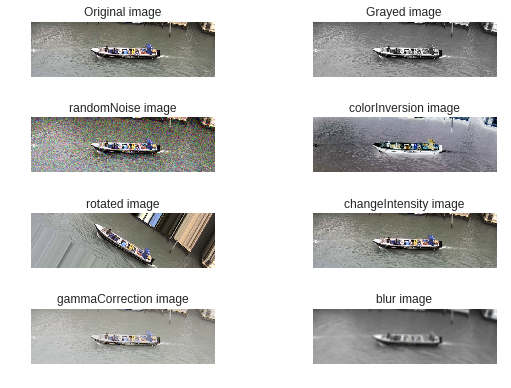

In [0]:
def showAdjustments(before, adjustments):
    fig, axes = plt.subplots(nrows=4, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(before, cmap='gray')
    ax[0].set_title('Original image')
    ax[0].axis('off')
    ax[1].imshow(colorToGray(before), cmap='gray')
    ax[1].set_title('Grayed image')
    ax[1].axis('off')
    for i, el in enumerate(adjustments):
      ax[i+2].imshow(el(before), cmap='gray')
      ax[i+2].set_title(el.__name__ + " image")
      ax[i+2].axis('off')
    plt.tight_layout()
    

randomPick = random.choice(os.listdir(trainFolder+"Mototopo"))
image = plt.imread(trainFolder + "Mototopo/" + randomPick)    
showAdjustments(image, adjustments)

# Datasets

In the following block three lists of categories are generated. The first one containing the names of the subfolders of the train set. The second one is obtained by opening the ground truth file and appending to the vector every category name (without repetition). As the two lists are not containing  the same strings, a third vector is required in order to list the **matching categories** from the two lists.

In [4]:
# Define train set category list
categoryList = list()
for category in os.listdir(trainFolder):
  if category not in categoryList and len(os.listdir(trainFolder+category)) > 100:
    categoryList.append(category)
categoryList.sort()

# Define test set category list
testCategoryList = list()
with open(testFolder + "ground_truth.txt") as file:
  for row in file:
    info = row.split(";")
    info = info[1].replace("\n", "").replace(":", "").replace(" ", "")
    if info not in testCategoryList:
      testCategoryList.append(info)
testCategoryList.sort()
file.close()

# Define category list belonging either to train and test set
matchingCategories = list()
for el in categoryList:
  if el in testCategoryList and el not in matchingCategories:
    matchingCategories.append(el)
matchingCategories.sort()
print("Chosen Categories: ")
for i in range(len(matchingCategories)):
  print('{:>3}'.format(i+1), matchingCategories[i])

Chosen Categories: 
  1 Alilaguna
  2 Barchino
  3 Lanciafino10mBianca
  4 Lanciafino10mMarrone
  5 Motobarca
  6 Mototopo
  7 Patanella
  8 VaporettoACTV


## Train Dataset



### HandMade

Try to find the pickle file in the folder, if the file is not found, the dataset needs to be created. In order to do it, first it reads image by image from the folders and, after a rescaling, append it to the features vector and the corresponding category index to the labels vector. For a matter of vector dimension, a gap of **300 images per category** is set, which is actually not enough for a perfect training, but it is for learning purposes.

In [3]:
# List for files
X_train = list()
y_train = list()
if os.path.isfile('training.p'):
    print('Training data file found!')
    with open('training.p', mode='rb') as f:
      train = pickle.load(f)
    X_train, y_train = train['features'], train['labels']
else:
  t1HM = time.time()
  for category in os.listdir(trainFolder):
    if category in matchingCategories:
      files = os.listdir(trainFolder + category)
      # Gap the image numers to 300
      gap = 300
      if len(files)<gap:
        gap = len(files)

      # If file is in classes to be classified
      i = matchingCategories.index(category)
      pbar = tqdm(range(gap), position=i)
      pbar.set_description('Processing \'' + category + '\'')

      # For each file
      for img in pbar:
          f = files[img]
          image = plt.imread(trainFolder + category + "/" + f)
          image = resize(image, (IMAGE_SIZE, IMAGE_SIZE))
          #image = rescale(image, SCALING_FACTOR)
          #image = colorToGray(image)
          X_train.append(image)
          y_train.append(matchingCategories.index(category))
  
  t2HM = time.time()
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  # Save dictionary
  save_data(X_train, y_train, 'training')
  print('\nTraining saved to file!')

Processing 'Lanciafino10mBianca': 100%|██████████| 300/300 [02:50<00:00,  1.89it/s]


### Pre-Built

The library TFLearn provides an easy and useful way to deal with keeping in memory a huge bunch of images. In fact, through the function *image_preloader*, it creates a python array (**Preloader**) that loads images on the fly (from disk or url).

The approach of the function is basically the same of the HandMade: given a folder, it reads subfolder by subfolder and then image by image. It loads the images inside the features vector and transform the corresponding subfolders name into a **one-hot encoded array** before appending it to the labels vector. Also, the mentioned function can perform a *resize* of the images, during the loading, and a *normalization* of the entire dataset, if required.

Below is shown the difference in term of **weight of the variables** on the memory and **time spent** to create the variable, keeping in mind that the HandMade code is considering and storing only 8 categories with a gap of 300 images per category. The prebuilt function, on the contrary, stores the whole dataset of about 4.5k images.

In [0]:
t1PB = time.time()
X = None
Y = None
X, Y = image_preloader(trainFolder, image_shape=(224, 224),   mode='folder', categorical_labels=True,   normalize=True)
t2PB = time.time()

### Results

In [0]:
print("#"*80)
print("HandMade Function")
print("\tNumber of Samples: {} \n\tWeight on the Memory: {} bytes\n\tTime Spent to Create the Variable: {} s"
     .format(len(X_train), getsizeof(X_train), t2HM-t1HM))
print("#"*80)
print("PreBuilt Function")
print("\tNumber of Samples: {} \n\tWeight on the Memory: {} bytes\n\tTime Spent to Create the Variable: {} s"
     .format(len(X), getsizeof(X), t2PB-t1PB))
print("#"*80)

################################################################################
HandMade Function
	Number of Samples: 1919 
	Weight on the Memory: 138168144 bytes
	Time Spent to Create the Variable: 557.0226535797119 s
################################################################################
PreBuilt Function
	Number of Samples: 3867 
	Weight on the Memory: 56 bytes
	Time Spent to Create the Variable: 0.05990910530090332 s
################################################################################


## Test Dataset

The process to create the test dataset is basically the same as the training dataset, but here it is a little bit different because the files are all together, not divided by folders. The image names and their relative labels are stored in a txt file called **"ground_truth"**, in the format:

`20130412_043335_55056.jpg;Mototopo`

The "ground truth" file is read line by line, adjusting the found label and adding the corresponding image to the test vector, only if its label is contained in the vector of the chosen categories.

As for the train dataset, if the pickle dataset file is found inside the folder, then it is loaded instad of creating a new vector.

In [6]:
X_test = list()
y_test = list()
if os.path.isfile('test.p'):
    print('Test data file found!')
    with open('test.p', mode='rb') as f:
      test = pickle.load(f)
    X_test, y_test = test['features'], test['labels']
else:  
  testDictionary = {}
  with open(testFolder + 'ground_truth.txt', 'r') as file:
    for row in file:
      image, categoryName = row.strip().split(';')
      categoryName = categoryName.replace(":", "").replace(" ", "")
      #print(categoryName)
      if categoryName in matchingCategories:
          testDictionary[image] = categoryName
  #print(testDictionary)
  pbar = tqdm(range(len(testDictionary)), position = 0)
  pbar.set_description('Processing test data')

  keys = list(testDictionary)

  for f in pbar:
      image = plt.imread(testFolder + "/" + keys[f])
      image = resize(image, (IMAGE_SIZE, IMAGE_SIZE))
      #image = colorToGray(image)
      #image = changeSize(image)
      #image = rescale(image, SCALING_FACTOR)
      X_test.append(image)
      y_test.append(matchingCategories.index(testDictionary[keys[f]]))

  X_test = np.array(X_test)
  y_test = np.array(y_test)

  # Save dictionary
  save_data(X_test, y_test, 'test')
  print('\nTest saved to file!')

Processing test data: 100%|██████████| 1144/1144 [12:15<00:00,  1.67it/s]


## Dataset Recap

The script below is used to print some basic information about the dataset, such as the number of files in each dataset, the shape of the images and the classes being classified.

In [0]:
labelCount = {}
total = 0
for category in os.listdir(trainFolder):
  if category in matchingCategories:
    labelCount[category] = len(os.listdir(trainFolder + category))

print("Number of training examples =", len(X_train))
print("Number of testing examples =", len(X_test))
print("Image data shape =", X_train[0].shape)
print("Number of classes =", len(labelCount))
print("Classes and Samples Count: \n")
for k in labelCount:
  if labelCount[k] > 300:
    print('{:>3}'.format(300), k)
  else:  
    print('{:>3}'.format(labelCount[k]), k)

Number of training examples = 1919
Number of testing examples = 1144
Image data shape = (224, 224, 3)
Number of classes = 8
Classes and Samples Count: 

215 Motobarca
279 Patanella
300 Lanciafino10mMarrone
300 Mototopo
300 VaporettoACTV
113 Alilaguna
112 Barchino
300 Lanciafino10mBianca


# Image Preprocessing



## Scaling

One of the first steps is to ensure that the images have the **same size and aspect ratio**. Most of the neural network models assume a square shape input image, which means that each image need to be checked if it is a square or not, and cropped appropriately. 

Plus, most of the neural network models assume a square shape input image, which means that each image need to be checked if it is a square or not, and cropped appropriately. Also the ConvNet VGG which has been used for this project, requires a squared dimension of the images in input. Specifically the image must have 244 pixel of dimension.

## Mean and Standard Deviation

Sometimes it’s useful for the network to look at the **Mean Image** obtained by taking the mean values for each pixel across all training examples. Observing this could give us insight into some underlying structure in the images.

Below the code to generate the Mean Image from the training set.

In [0]:
meanImage = np.zeros((224,224,3))
for nImage, el in enumerate(X_train):
  for row in range(len(el)):
    for col in range(len(el[row])):
      for chan in range(len(el[row][col])):
        meanImage[row][col][chan]+=el[row][col][chan]
meanImage /= len(X_train)


## Normalization

**Data normalization**, instead, is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. Data normalization is done by subtracting the *mean* from each pixel, and then dividing the result by the *standard deviation*. The distribution of such data would resemble a Gaussian curve centered at zero. 

Below the code to generate the Standard Deviation Image from the training set.

In [0]:
stdImage = np.zeros((224, 224, 3))
for nImage, el in enumerate(X_train):
  for row in range(len(el)):
    for col in range(len(el[row])):
      for chan in range(len(el[row][col])):
        stdImage[row][col][chan]+=pow((el[row][col][chan]-meanImage[row][col][chan]), 2)
stdImage /= len(X_train)
stdImage = np.sqrt(stdImage)

The *mean image* showed on the left could give us insight into some underlying structure in the images. It lets us conclude that the boats are somewhat aligned to the center but they're of different sizes, as expected.

The *standard deviation* of all images is shown to the right. Higher variance values show up whiter, so we see that the pictures vary a lot at the center compared to the boundaries.

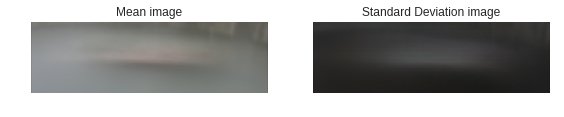

In [0]:
def showImages(before, after):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(before, cmap='gray')
    ax[0].set_title("Mean image")

    ax[1].imshow(after, cmap='gray')
    ax[1].set_title("Standard Deviation image")
    
    ax[0].axis('off')
    ax[1].axis('off')
    plt.tight_layout()
    
showImages(resize(meanImage, (240, 800)), resize(stdImage, (240, 800)))

After defining the **Mean Image** and the **Standard Deviation Image**, we need to apply those masks, subtracting the first one and diving the second one from the training dataset. Beacuse the input are images we need the pixel numbers to be positive, so we might choose to scale the normalized data in the range [0,1] or [0, 255].

In [0]:
for nImage, el in enumerate(X_train):
  for row in range(len(el)):
    for col in range(len(el[row])):
      for chan in range(len(el[row][col])):
        el[row][col][chan]-=meanImage[row][col][chan]
        el[row][col][chan]/=stdImage[row][col][chan]
       
X_train = np.interp(X_train, (X_train.min(), X_train.max()), (0,1))

In [0]:
for nImage, el in enumerate(X_test):
  for row in range(len(el)):
    for col in range(len(el[row])):
      for chan in range(len(el[row][col])):
        el[row][col][chan]-=meanImage[row][col][chan]
        el[row][col][chan]/=stdImage[row][col][chan]
       
X_train = np.interp(X_test, (X_test.min(), X_test.max()), (0,1))

In the following block is instead shown how the images of the dataset look like after the Normalization.

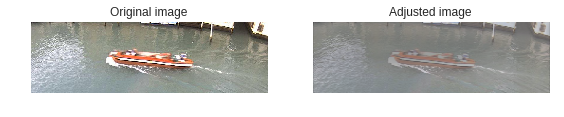

In [0]:
def showImages(before, after):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(before, cmap='gray')
    ax[0].set_title("Original image")

    ax[1].imshow(after, cmap='gray')
    ax[1].set_title("Adjusted image")
    
    ax[0].axis('off')
    ax[1].axis('off')
    plt.tight_layout()
    
firstImage = os.listdir(trainFolder + "Motobarca/")[0]
showImages(plt.imread(trainFolder + "Motobarca/" + firstImage), resize(X_train[0], (240, 800)))

## Dimensionality Reduction

We could also choose to collapse the RGB channels into a single **gray-scale channel**. There are often considerations to reduce other dimensions, when the neural network performance is allowed to be invariant to that dimension, or to make the training problem more tractable.

Here it is not applied.



## Data Augmentation

Another common pre-processing technique involves augmenting the existing data-set with perturbed versions of the existing images. *Scaling, rotations and other affine transformations* are typical. This is done to expose the neural network to a wide variety of variations. This makes it less likely that the neural network recognizes unwanted characteristics in the data-set.

Although for us, seeing two slightly different images does not make any difference, for the classifier these **augmentation** cause a big impact and it can be really used as new dataset.

Moreover, as shown above, the number of examples in each class is not the same, and to create a good classifier it is important to have a **balanced dataset**, made through this kind of transformation.

The function below selects randomly images from the categories which samples don't reach the gap value and applies a random transformation, from the above-mentioned, in order to match the number of examples of the biggest class (300 images). 

A new pickle dataset file is created after the dataset balancing so this passage can be avoided the next time.

In [5]:
if os.path.isfile('training_augmented.p'):
  print('Training file found!')
  with open('training_augmented.p', mode='rb') as f:
    trainAugmented = pickle.load(f)
  X_train, y_train = trainAugmented['features'], trainAugmented['labels']
else:
  print('Training augmented file not found\n')
  count = 0
  gap = 300
  for label in labelCount:
    nActual = labelCount[label]
    fileList = os.listdir(trainFolder+label)
    if nActual<gap:
      pbar = tqdm(range(gap-nActual), position = count)
      pbar.set_description('Processing images')
      for f in pbar:
        randomPick = random.choice(fileList)
        image = plt.imread(trainFolder + label + "/" + randomPick)
        image = resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        #image = rescale(image, SCALING_FACTOR)
        image = random.choice(adjustments)(image)
        X_train = np.append(X_train, [image], axis=0)
        y_train = np.append(y_train, matchingCategories.index(label))
      #print(X_train.shape)
      count += 1
  save_data(X_train, y_train, 'training_augmented.p')
  print('Training augmented saved to file!')

Processing images: 100%|██████████| 188/188 [02:38<00:00,  1.15it/s]


Two more steps are still required for this process and performed in the next lines:

*   Shuffle - used to avoid mini batches during training
*   One-hot encode labels - used to represent the classes where each bit is one class and not an int number

In [0]:
# One Hot encode the labels to the variable y_one_hot
y_train = to_categorical(y_train, len(matchingCategories))
y_test = to_categorical(y_test, len(matchingCategories))

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train)

# Change to float32, so it can be multiplied
# against the features in TensorFlow, which are float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# Convolutional Neural Network

Convolutional Neural Networks receive an input (a single vector), and transform it through a series of **hidden layers**. Each hidden layer is made up of a set of **neurons**, where each neuron is fully connected to all neurons in the previous layer, and where neurons in a single layer function completely independently and do not share any connections. The last **fully-connected layer** is called the “output layer” and in classification settings it represents the class scores.

Several kinds of *ConvNets* have been tried for this project, from an **HandMade** model, to the most common and spread **VGGNet**  to the lightweight and quick **AlexNet**. All the results have been gathered and showed below.


## HandMade

Some common and well-know lines have been followed in order to generate this model.

### Layers

Convolutional Networks are commonly made up of only four layer types: **Convolutional**, **Activation**, **Pooling**  and **Fully-Connected**. 

The most common form of a ConvNet architecture stacks a few CONV-RELU layers, follows them with POOL layers, and repeats this pattern until the image has been merged spatially to a small size. At some point, it is common to transition to fully-connected layers. The last fully-connected layer holds the output, such as the class scores.

### Hyperparametes

The **input layer** (that contains the image) should be divisible by 2 many times. Common numbers include 32 (e.g. CIFAR-10), 64, 96 (e.g. STL-10), or 224 (e.g. common ImageNet ConvNets), 384, and 512.

The **conv layers** should be using small filters (e.g. 3x3 or at most 5x5).

The **pool layers** are in charge of downsampling the spatial dimensions of the input. The most common setting is to use max-pooling with 2x2 receptive fields, and with a stride of 2. Note that this discards exactly 75% of the activations in an input volume (due to downsampling by 2 in both width and height). 

From this assumptions, an HandMade Model of ConvNet has been made, designed to be as *easy* and *lightweight* as possibile.

In [0]:
height, width, depth = X_train[0].shape
print(height, width, depth)
print(y_train.shape)

In [0]:
convnet = input_data(shape =[None, height, width, depth], name ='input') 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 2, strides=2) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 2, strides=2) 
  
convnet = conv_2d(convnet, 128, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 2, strides=2) 
  
convnet = fully_connected(convnet, 1024, activation ='relu') 
convnet = dropout(convnet, 0.8) 
  
convnet = fully_connected(convnet, 8, activation ='softmax') 
convnet = regression(convnet, optimizer ='adam', learning_rate = LEARNING_RATE, 
      loss ='categorical_crossentropy', name ='targets') 
  
model = tflearn.DNN(convnet, tensorboard_verbose=3, tensorboard_dir ='log') 
  

### Input

For this first model they have been considered squared images of size 224 pixels. Besides the training samples, they have been added also a total amount of about 400 augmented images in order to balance the dataset.

In [0]:
MODEL_NAME = 'veniceBoats.model'
model.fit({'input': X_train}, {'targets': y_train}, n_epoch = 20,  
    validation_set =({'input': X_test}, {'targets': y_test}),  
    snapshot_step = 500, show_metric = True, run_id = MODEL_NAME)
model.save(MODEL_NAME)

Training Step: 759  | total loss: 0.17076 | time: 126.612s
| Adam | epoch: 020 | loss: 0.17076 - acc: 0.9402 -- iter: 2368/2400
Training Step: 760  | total loss: 0.16500 | time: 131.131s
| Adam | epoch: 020 | loss: 0.16500 - acc: 0.9414 | val_loss: 1.14978 - val_acc: 0.7614 -- iter: 2400/2400
--
INFO:tensorflow:/content/drive/My Drive/veniceBoats.model is not in all_model_checkpoint_paths. Manually adding it.


The same model it has been trained with a different dataset, composed by training images preprocessed with *Mean Subtraction* and *Normalization* and no augmented images. The comparition between the results of the two training is showed below.


In [0]:
MODEL_NAME = 'veniceBoatsPreProcessed.model'
model.fit({'input': X_train}, {'targets': y_train}, n_epoch = 20,  
    validation_set =({'input': X_test}, {'targets': y_test}),  
    snapshot_step = 500, show_metric = True, run_id = MODEL_NAME)
model.save(MODEL_NAME)

Training Step: 599  | total loss: 0.81946 | time: 117.523s
| Adam | epoch: 020 | loss: 0.81946 - acc: 0.6652 -- iter: 1856/1919
Training Step: 600  | total loss: 0.81377 | time: 122.567s
| Adam | epoch: 020 | loss: 0.81377 - acc: 0.6706 | val_loss: 6.32219 - val_acc: 0.3601 -- iter: 1919/1919
--
INFO:tensorflow:/content/drive/My Drive/veniceBoatsPreProcessed.model is not in all_model_checkpoint_paths. Manually adding it.


## VGG Net

This network contains 16 CONV/FC layers and, appealingly, features an extremely homogeneous architecture that only performs 3x3 convolutions and 2x2 pooling from the beginning to the end. A downside of the VGGNet is that it is more expensive to evaluate and uses a lot more memory and parameters (140M).

A pretrained model is also avaible for plug and play use, but it is missing for the specific library (TFLearn) which has been used in this project. 

In [0]:
# Building 'VGG Network'
network = input_data(shape=[None, 224, 224, 3])

network = conv_2d(network, 64, 3, activation='relu')
network = conv_2d(network, 64, 3, activation='relu')
network = max_pool_2d(network, 2, strides=2)

network = conv_2d(network, 128, 3, activation='relu')
network = conv_2d(network, 128, 3, activation='relu')
network = max_pool_2d(network, 2, strides=2)

network = conv_2d(network, 256, 3, activation='relu')
network = conv_2d(network, 256, 3, activation='relu')
network = conv_2d(network, 256, 3, activation='relu')
network = max_pool_2d(network, 2, strides=2)

network = conv_2d(network, 512, 3, activation='relu')
network = conv_2d(network, 512, 3, activation='relu')
network = conv_2d(network, 512, 3, activation='relu')
network = max_pool_2d(network, 2, strides=2)

network = conv_2d(network, 512, 3, activation='relu')
network = conv_2d(network, 512, 3, activation='relu')
network = conv_2d(network, 512, 3, activation='relu')
network = max_pool_2d(network, 2, strides=2)

network = fully_connected(network, 4096, activation='relu')
network = dropout(network, 0.5)
network = fully_connected(network, 4096, activation='relu')
network = dropout(network, 0.5)
network = fully_connected(network, 8, activation='softmax')

network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.0001)
# Training
model = tflearn.DNN(network, tensorboard_verbose=3, tensorboard_dir='log')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Beacause of the huge size of this model, it has been chosen to stop the training before the end. It will be not considered in the final results.

In [0]:
MODEL_NAME = 'veniceBoatsVGG.model'

#model.load("weights/vgg16_weights.h5")
model.fit(X, Y, n_epoch = 20, 
    snapshot_step = 500, show_metric = True, run_id = MODEL_NAME)
model.save(MODEL_NAME)

Training Step: 27  | total loss: 1.94434 | time: 952.632s
| Adam | epoch: 001 | loss: 1.94434 - acc: 0.2584 -- iter: 1728/1923


## AlexNet

This Network had a very similar architecture to LeNet, but was deeper, bigger, and featured Convolutional Layers stacked on top of each other (previously it was common to only have a single CONV layer always immediately followed by a POOL layer).

### Dataset

In order to use the *ImagePreloader* of the TFLearn libary mentioned above,  creating the RIGHT input dataset, instead of loading all the images from all the categories, two different txt files have been generated. Those are the requirements needed by the function that loads the images insed the Preloader. 

The text files contain the image names and their relative labels from, respectively, the train and the test dataset.   

Plus, the images generated by the augmentation have been phisically stored inside the memory and added to the txt train file to be loaded by the preloader.

Augmented images storing:

In [0]:
count = 0
gap = 300
for label in labelCount:
  nActual = labelCount[label]
  fileList = os.listdir(trainFolder+label)
  if nActual<gap:
    pbar = tqdm(range(gap-nActual), position = count)
    pbar.set_description('Processing images')
    for f in pbar:
      randomPick = random.choice(fileList)
      image = plt.imread(trainFolder + label + "/" + randomPick)
      image = random.choice(adjustments)(image)
      imsave('augmented/' + label + '/' + randomPick.replace(".jpg", "") 
             + '_AUG.jpg', image)
    count += 1

Processing images: 100%|██████████| 188/188 [00:10<00:00, 19.14it/s]


Creation of the train and test dataset text file:

In [0]:
if os.path.isfile('trainDict'):
  print("Train Dictionary already in the folder")
else:
  normCount = 0
  augCount = 0
  print("Generating Train Dictionary")
  with open("trainDict", 'w+') as f:
    for i, label in enumerate(os.listdir(trainFolder)):
      if label in matchingCategories:
        imageCount = 0
        for j, image in enumerate(os.listdir(trainFolder + label)):
          if imageCount <= gap:
            f.write(trainFolder + label + "/" + image + " " 
                    + str(matchingCategories.index(label)) + "\n")
            imageCount += 1
            normCount += 1
    for i, label in enumerate(os.listdir('augmented/')):
      if label in matchingCategories:
        for j, image in enumerate(os.listdir('augmented/' + label)):
          f.write('augmented/' + label + "/" + image + " " 
                  + str(matchingCategories.index(label)) + "\n")
          augCount += 1
  f.close()
  print('Done')

Generating Train Dictionary
Done


In [0]:
if os.path.isfile('testDict'):
  print("Test Dictionary already in the folder")
else:
  print("Generating Test Dictionary")
  with open(testFolder + "ground_truth.txt") as file:
    with open('testDict', 'w+') as f:
      for row in file:
        info = row.split(";")
        name = info[0]
        label = info[1].replace("\n", "").replace(":", "").replace(" ", "")
        if label in matchingCategories:
          f.write('test/' + name + ' ' + str(matchingCategories.index(label)) + '\n')
  f.close()
  file.close()
  print("Done")

Generating Test Dictionary
Done


Loading and shuffling the data:

In [0]:
X, Y = image_preloader('trainDict', image_shape=(227, 227), mode='file', 
                       categorical_labels=True, normalize=True)


In [0]:
Xtest, Ytest = image_preloader('testDict', image_shape=(227, 227), mode='file', 
                       categorical_labels=True, normalize=True)

In [0]:
X, Y = shuffle(X, Y)
Xtest, Ytest = shuffle(Xtest, Ytest)

### Model

In [11]:
# Building 'AlexNet'
network = input_data(shape=[None, 227, 227, 3])
network = conv_2d(network, 96, 11, strides=4, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = conv_2d(network, 256, 5, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = conv_2d(network, 384, 3, activation='relu')
network = conv_2d(network, 384, 3, activation='relu')
network = conv_2d(network, 256, 3, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = fully_connected(network, 4096, activation='tanh')
network = dropout(network, 0.5)
network = fully_connected(network, 4096, activation='tanh')
network = dropout(network, 0.5)
network = fully_connected(network, 8, activation='softmax')
network = regression(network, optimizer='momentum',
                     loss='categorical_crossentropy',
                     learning_rate=0.001)
# Training
model = tflearn.DNN(network, tensorboard_verbose=3, tensorboard_dir='log')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
MODEL_NAME = 'veniceBoatsAlexNet.model'

model.fit(X, Y, n_epoch = 20, validation_set = (Xtest, Ytest),
    snapshot_step = 500, show_metric = True, run_id = MODEL_NAME)
model.save(MODEL_NAME)

Training Step: 699  | total loss: 0.78516 | time: 224.707s
| Momentum | epoch: 020 | loss: 0.78516 - acc: 0.7222 -- iter: 2176/2193
Training Step: 700  | total loss: 0.77964 | time: 232.579s
| Momentum | epoch: 020 | loss: 0.77964 - acc: 0.7187 | val_loss: 0.86762 - val_acc: 0.6740 -- iter: 2193/2193
--
INFO:tensorflow:/content/drive/My Drive/veniceBoatsAlexNet.model is not in all_model_checkpoint_paths. Manually adding it.


# Results and Conclusions

The graphs below highlight some interesting features from the various trainings.



*   The **orange line** belongs to the first training, with augmented data and no normalization
*   The **blu line** belongs to the second training, with normalization and no augmented data
*   The **red line** belongs to the last training, on AlexNet Model



## Accuracy

Differently from the expectactions, the HandMade model, in the case of the first training, performed better than the Pre-Build AlexNet model, either for the Training and the Validation. It may depends on the fact that the HandMade has specifically been made for this kind of training.

The normalized dataset is also perfoming well in the training but not better than the first one. This may happen because the normalize dataset hasn't been augmented . The results in the validation accuracy are likely to be so bad because the same normalization hasn't been applied on the validation dataset too.

![accuracy](https://i.ibb.co/BLNpyXX/accuracy.png)


## Loss

The same results seen for the accuracy are found in the loss. The loss of the validation is affected by an interesting behaviour. It is in fact growing, instead of decreasing. This is probably beacuse the validation dataset is non-representative of the the problem should be solved.

![loss](https://i.ibb.co/qR93bMy/Loss.png)

## Further Improvements

A better training could be perfomed on the Normalized dataset, applying the normalization also on some more augmented data and on the validation dataset.

Also, a finetuning of a pretrained VGG model could be tried, in order to reduce the time spent to train.